In [16]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [17]:
# create a transofrm to apply to each datapoint
from torchvision import transforms

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((10, 10))
])
# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

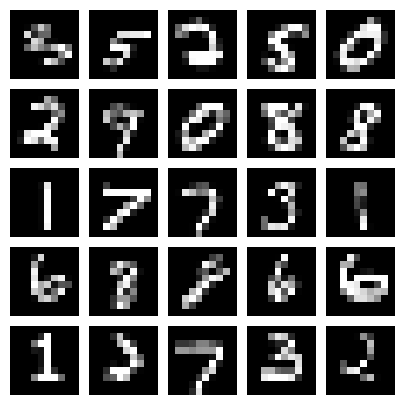

In [18]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [19]:
class VAE(nn.Module):

    def __init__(self, input_dim=100,  latent_dim=20, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),

        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [20]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [21]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(
        x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [24]:
def train(model, optimizer, epochs, device, x_dim=100):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ",
              overall_loss/(batch_idx*batch_size))
    return overall_loss

In [25]:
train(model, optimizer, epochs=10, device=device)

	Epoch 1 	Average Loss:  35.30996886493766
	Epoch 2 	Average Loss:  27.30749798655311
	Epoch 3 	Average Loss:  26.093828679309265
	Epoch 4 	Average Loss:  25.322895271415902
	Epoch 5 	Average Loss:  25.075948537275668
	Epoch 6 	Average Loss:  24.987297726027755
	Epoch 7 	Average Loss:  24.928944835631
	Epoch 8 	Average Loss:  24.87141643135695
	Epoch 9 	Average Loss:  24.82966221779137
	Epoch 10 	Average Loss:  24.806025622945796


1485880.9348144531

In [28]:
# Assuming decoder_model is your PyTorch decoder model
from os import write
weights_and_biases = []
for layer in [*model.modules()][1:]:
    if isinstance(layer, nn.Sequential):
        continue
    print(layer)
    if isinstance(layer, nn.Linear):
        w = layer.weight
        w = w.data
        w = w.cpu()
        w = w.numpy()
        b = layer.bias
        b = b.data
        b = b.cpu()
        b = b.numpy()
        weights_and_biases.append((w, b))
fixed_point_weights_and_biases = []
for weight, biase in weights_and_biases:
    fixed_point_weight = (weight * (2**15)).astype(np.int16)
    fixed_point_biase = (biase * (2**15)).astype(np.int16)
    fixed_point_weights_and_biases.append(
        (fixed_point_weight, fixed_point_biase))
for i, (w, b) in enumerate(fixed_point_weights_and_biases):
    s = []
    for row in w:
        s.append(", ".join([str(x) for x in row]))
    s = "\n".join(s)
    file = open(f"w{i}.txt", 'w')
    file.write(s)
    file.close()
    s = ", ".join([str(x) for x in b])
    file = open(f"b{i}.txt", 'w')
    file.write(s)
    file.close()

Linear(in_features=100, out_features=20, bias=True)
ReLU()
Linear(in_features=20, out_features=2, bias=True)
Linear(in_features=20, out_features=2, bias=True)
Linear(in_features=2, out_features=20, bias=True)
ReLU()
Linear(in_features=20, out_features=100, bias=True)
Sigmoid()


In [26]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(10, 10)  # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

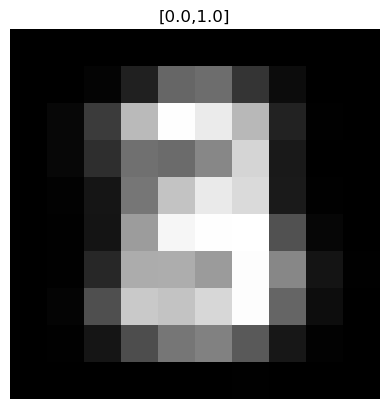

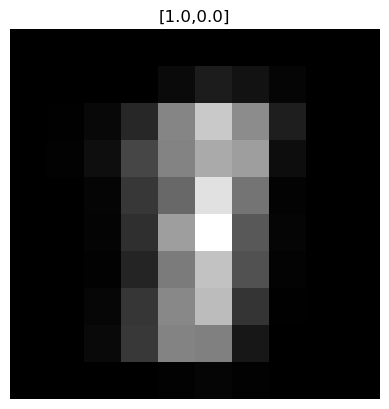

(None, None)

In [27]:
# img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [31]:
import torch
import torch.nn as nn


class QuantizedDecoder(nn.Module):
    def __init__(self, input_dim=2, latent_dim=20, output_dim=100, bits=16):
        super(QuantizedDecoder, self).__init__()
        self.bits = bits
        self.scale = 2**(bits-1) - 1
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(),

            nn.Linear(latent_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = z
        for layer in self.decoder:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                x = (x).round().int().float() / self.scale
        return x

    def load_pretrained_weights(self, vae_model):
        self.decoder.load_state_dict(vae_model.decoder.state_dict())

    def quantize_weights(self):
        for param in self.parameters():
            param.data = (
                param.data * self.scale).round().int().float()

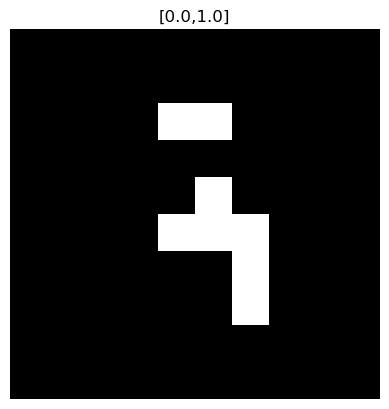

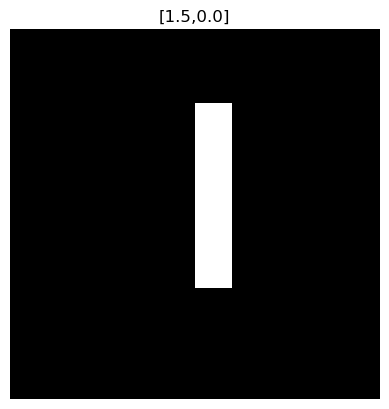

(None, None)

In [33]:

quantized_decoder = QuantizedDecoder().to('cuda')


quantized_decoder.load_pretrained_weights(model)

# Quantize the weights
quantized_decoder.quantize_weights()


def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = quantized_decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(10, 10)
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()


generate_digit(0.0, 1.0), generate_digit(1.5, 0.0)

In [ ]:

for param in quantized_decoder.parameters():
    print(param)


def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = quantized_decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()
    return x_decoded

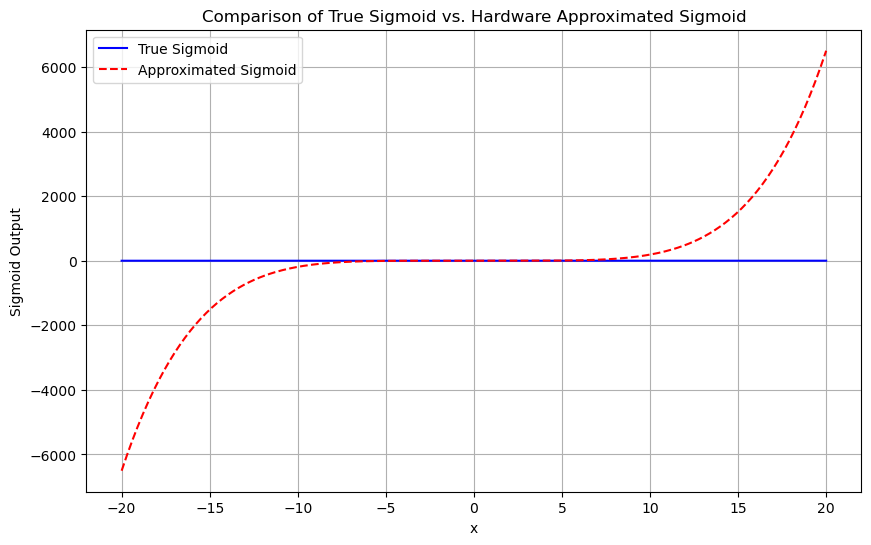

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_approximation(x):
    y = 0.5 + x / 4 - x**3 / 48 + x**5 / 480
    return y


# Generate x values from -10 to 10 for plotting
x_values = np.linspace(-20, 20, 400)
# Calculate the actual sigmoid values
true_sigmoid_values = sigmoid(x_values)
# Calculate the approximated sigmoid values
approx_sigmoid_values = np.vectorize(sigmoid_approximation)(x_values)

# Plotting both functions
plt.figure(figsize=(10, 6))
plt.plot(x_values, true_sigmoid_values, label='True Sigmoid', color='blue')
plt.plot(x_values, approx_sigmoid_values,
         label='Approximated Sigmoid', linestyle='--', color='red')
plt.title('Comparison of True Sigmoid vs. Hardware Approximated Sigmoid')
plt.xlabel('x')
plt.ylabel('Sigmoid Output')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def plot_latent_space(quantized_decoder, scale=5.0, n=25, digit_size=10, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = quantized_decoder(z_sample)
            digit = x_decoded.detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('Quantized VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

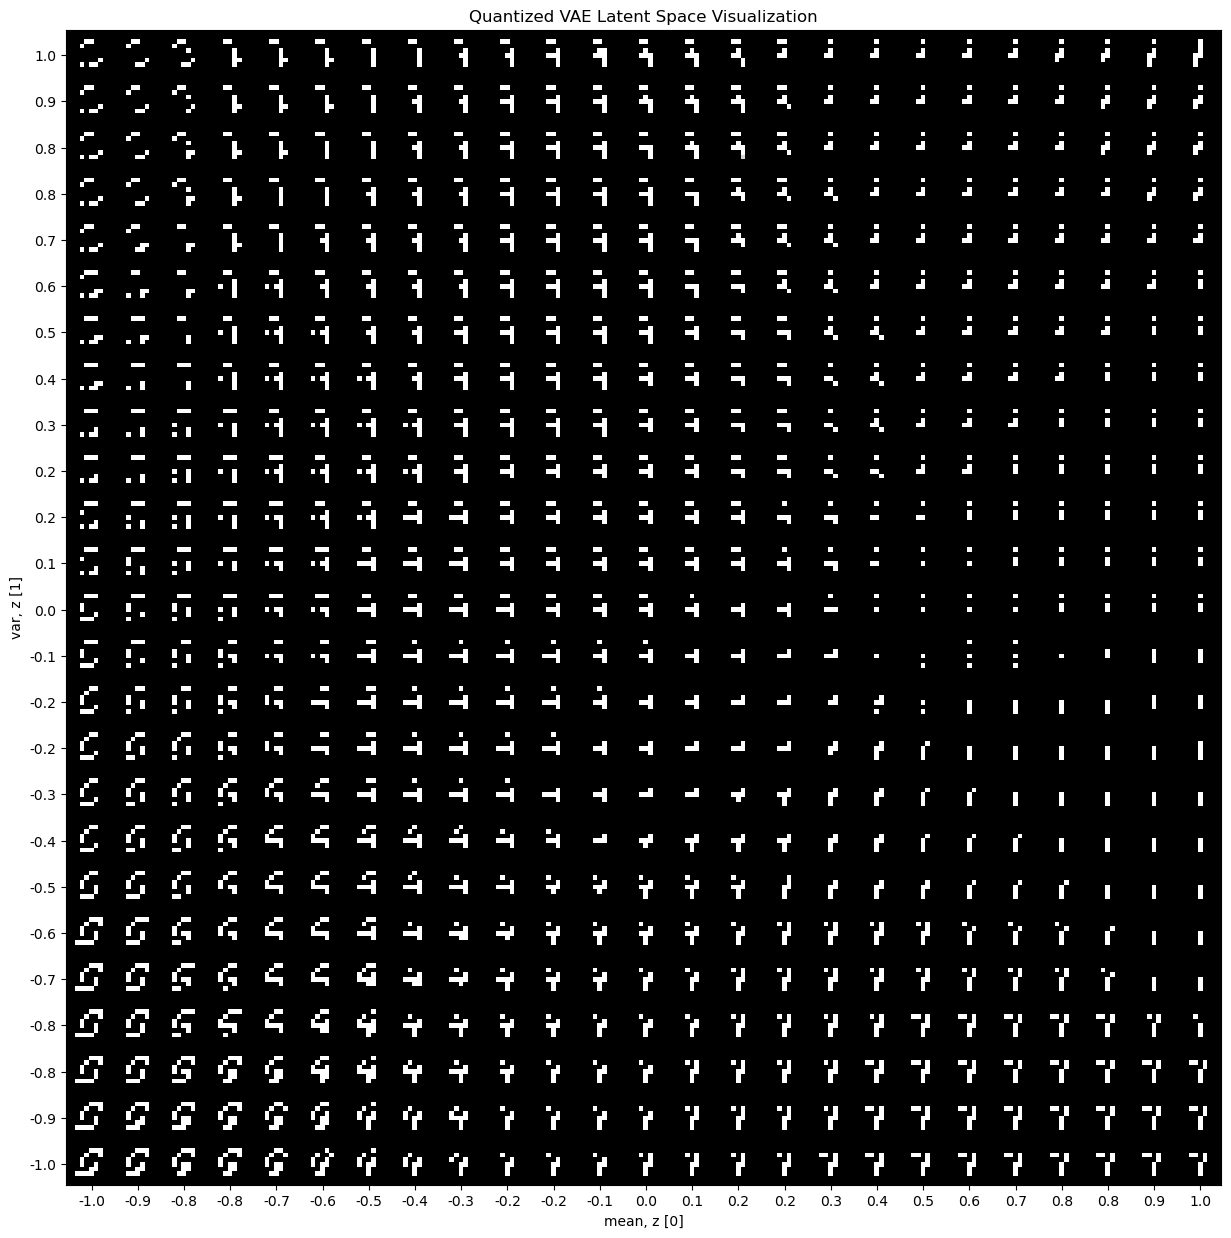

: 

In [35]:
plot_latent_space(quantized_decoder, scale=1.0)

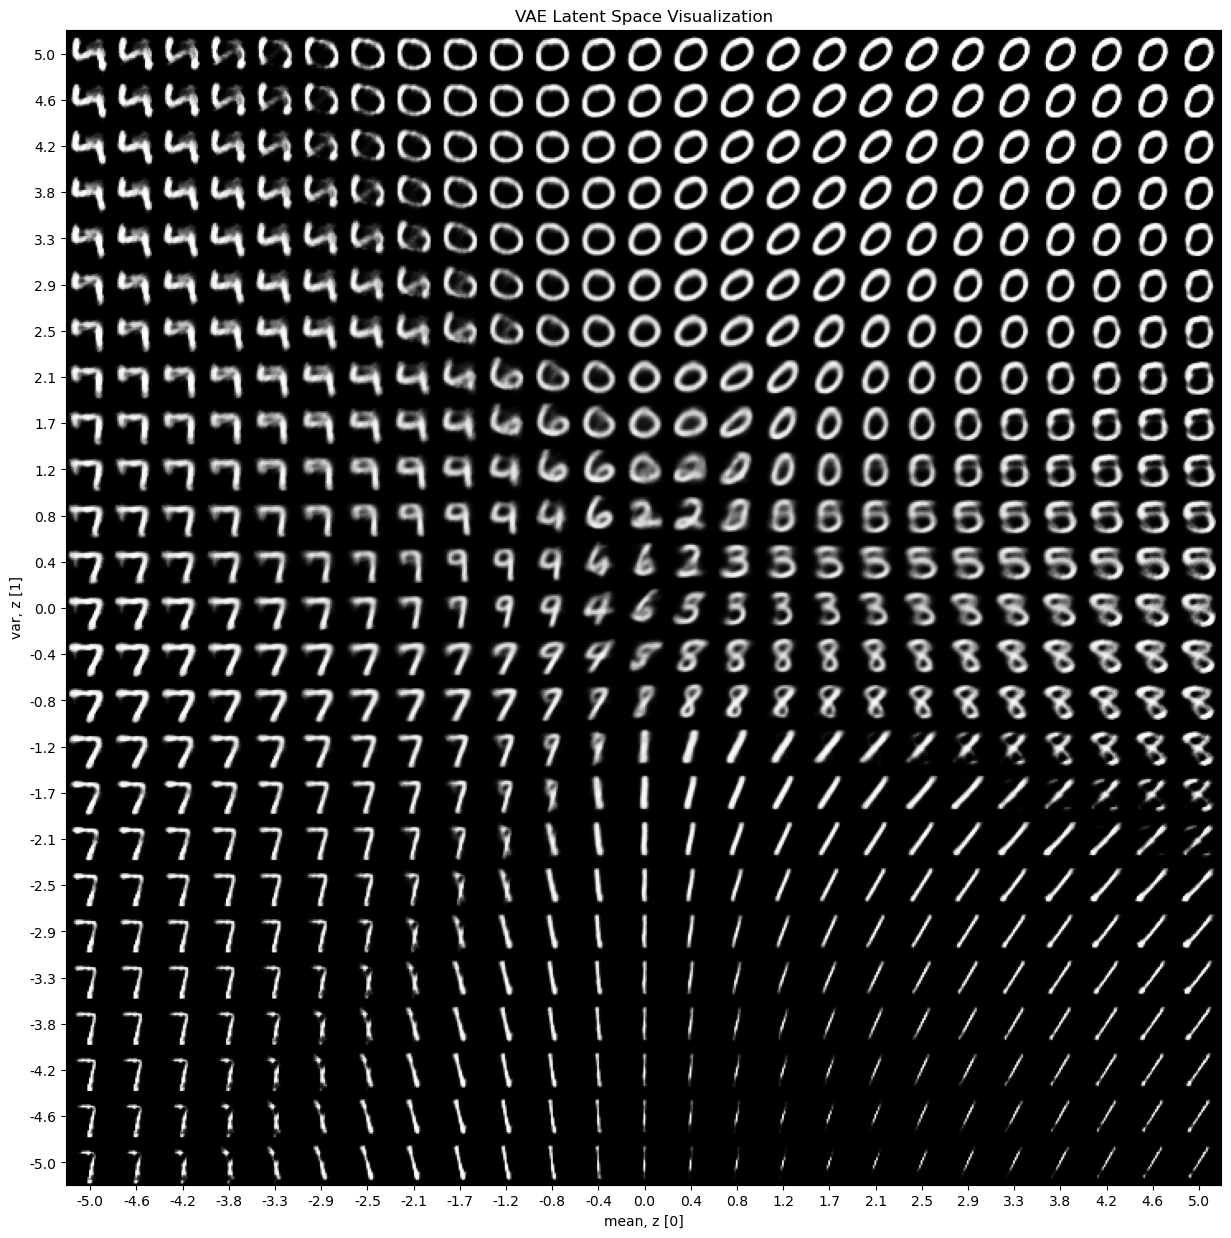

In [ ]:
plot_latent_space(model, scale=5.0)

In [ ]:
torch.save(model.state_dict(), './vae_model_state_dict.pth')